# EXPLICACION SEGUIDOR DE LINEA

En este notebook vamos a intentar ejecutar y explicar paso a paso como es que trata las imagenes opencv desde este codigo para poder detectar la linea y los diferentes cruces que tenemos de nuestro escenario !!

## 1.Importamos las librerias necesarias

In [11]:
import cv2
from camthreader import *
import numpy as np
import math
import serial

Una vez que tenemos la librerias vamos a tomar la imagen que necesitamos y le aplicaremos algunos filtros especiales, para eso primero definimos algunas variables que vamos a usar 

In [12]:
debugOriginal = True
debugBlack = True
debugHori = False
debugGreen = True
debugBlue = True
record = False

In [13]:
lower_black = np.array([0, 0, 0])  # BGR
upper_black = np.array([120, 120, 120])

Previo a realizar el ciclo en loop para cada imagen tomamos algunos parametros importante

In [14]:
import matplotlib.pyplot as plt

def mostrar_imagen_bgr(img_cv2):
    """
    Toma una imagen en formato OpenCV (BGR) y la muestra directamente en Jupyter Notebook.
    
    :param img_cv2: Imagen en formato OpenCV (BGR).
    """
    # Convertir la imagen de BGR a RGB (OpenCV usa BGR, Matplotlib usa RGB)
    img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    
    # Mostrar la imagen usando Matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')  # Ocultar los ejes
    plt.show()

def mostrar_imagen_hsv(img_hsv):
    """
    Toma una imagen en formato HSV y la muestra directamente en Jupyter Notebook.
    
    :param img_hsv: Imagen en formato HSV.
    """
    # Convertir la imagen de HSV a RGB (para que Matplotlib pueda mostrarla)
    img_rgb = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    
    # Mostrar la imagen usando Matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')  # Ocultar los ejes
    plt.show()

def mostrar_imagen_hsv_canales(img_hsv):
    """
    Toma una imagen en formato HSV y muestra sus tres canales (Hue, Saturation, Value)
    por separado en Jupyter Notebook.
    
    :param img_hsv: Imagen en formato HSV.
    """
    # Separar los tres canales: Hue, Saturation y Value
    hue_channel, saturation_channel, value_channel = cv2.split(img_hsv)
    
    # Crear una figura con subplots para mostrar los tres canales
    plt.figure(figsize=(10, 3))
    
    # Mostrar el canal H (Hue)
    plt.subplot(1, 3, 1)
    plt.imshow(hue_channel, cmap='hsv')
    plt.title('Canal H (Hue)')
    plt.axis('off')

    # Mostrar el canal S (Saturation)
    plt.subplot(1, 3, 2)
    plt.imshow(saturation_channel, cmap='gray')
    plt.title('Canal S (Saturation)')
    plt.axis('off')

    # Mostrar el canal V (Value)
    plt.subplot(1, 3, 3)
    plt.imshow(value_channel, cmap='gray')
    plt.title('Canal V (Value)')
    plt.axis('off')
    
    # Mostrar los tres canales juntos
    plt.show()

def mostrar_imagen_gris(image, title="Imagen"):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


Imagen Original


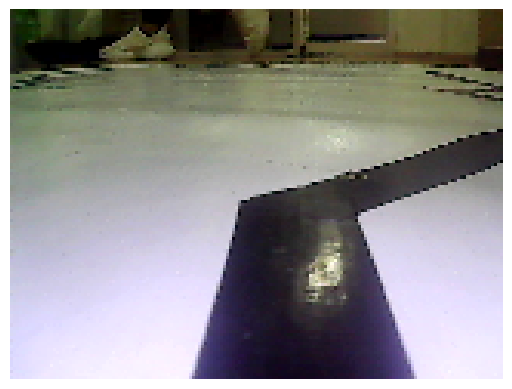

width: 160 | height: 120
cam_x: 79.0 | cam_y: 119


Para X_COM hace una matriz que va desde -1 hasta 1 en cada fila
[[-0.9875 -0.975  -0.9625 ...  0.975   0.9875  1.    ]
 [-0.9875 -0.975  -0.9625 ...  0.975   0.9875  1.    ]
 [-0.9875 -0.975  -0.9625 ...  0.975   0.9875  1.    ]
 ...
 [-0.9875 -0.975  -0.9625 ...  0.975   0.9875  1.    ]
 [-0.9875 -0.975  -0.9625 ...  0.975   0.9875  1.    ]
 [-0.9875 -0.975  -0.9625 ...  0.975   0.9875  1.    ]]

Para Y_COM hace una matriz que va desde O hasta 1 en cada columna
[[0.99166667 0.99166667 0.99166667 ... 0.99166667 0.99166667 0.99166667]
 [0.98333333 0.98333333 0.98333333 ... 0.98333333 0.98333333 0.98333333]
 [0.975      0.975      0.975      ... 0.975      0.975      0.975     ]
 ...
 [0.01666667 0.01666667 0.01666667 ... 0.01666667 0.01666667 0.01666667]
 [0.00833333 0.00833333 0.00833333 ... 0.00833333 0.00833333 0.00833333]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [5]:
# test_frame = vs.read()
test_frame = cv2.imread("C:/Users/enzzo/Documents/IITA/Roboliga-2024-Rescue-Line-Team-RescueBot/rpi/desktop/img/turn_line.png")

# Mostrar la imagen en una ventana
print("Imagen Original")
mostrar_imagen_bgr(test_frame)
width, height = test_frame.shape[1], test_frame.shape[0]
print(f"width: {width} | height: {height}")

cam_x = width / 2 - 1   # 79 ~ middle coloumn
cam_y = height - 1      # 119 ~ bottom row
print(f"cam_x: {cam_x} | cam_y: {cam_y}")
print()
# GET X AND Y ARRAYS
# scaled by frame dimensions, use this for filtering pixels
x_com = np.zeros(shape=(height, width)) # Crea dos matrices de ceros de numpy
y_com = np.zeros(shape=(height, width))
for i in range(height):
    for j in range(width):
        x_com[i][j] = (j - cam_x) / (width / 2)   # [-1, 1]
        y_com[i][j] = (cam_y - i) / height        # [0, 1]

print()
print("Para X_COM hace una matriz que va desde -1 hasta 1 en cada fila")
print(x_com)
print()
print("Para Y_COM hace una matriz que va desde O hasta 1 en cada columna")
print(y_com)
cccounter=0

Ahora si empezamos con la imagen como tal

Imagen Original


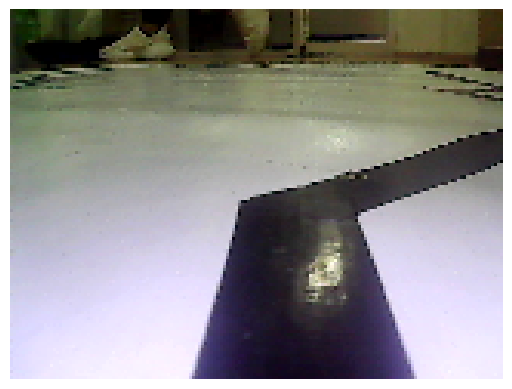

Imagen Recortada


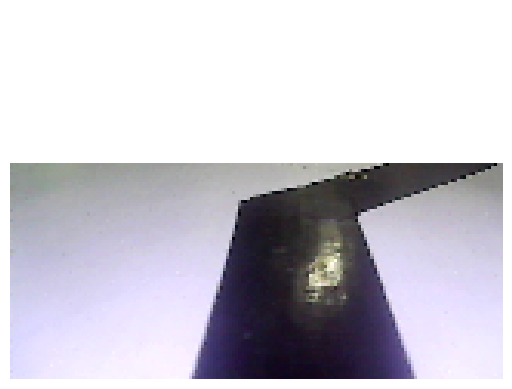

[[1 1 1]
 [1 1 1]
 [1 1 1]]
Imagen que usa para el Green


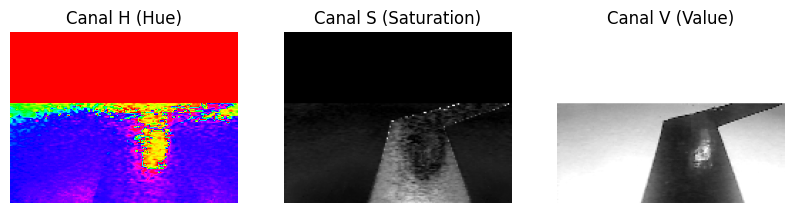

In [6]:
frame = test_frame
print("Imagen Original")
mostrar_imagen_bgr(test_frame)
frame[:50, :, :] = 255          # ignore top 1/8 of frame
print("Imagen Recortada")
mostrar_imagen_bgr(frame)
kernel = np.ones((3, 3), np.uint8)
print(kernel)
print("Imagen que usa para el Green")
hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
mostrar_imagen_hsv_canales(hsv_frame)


De la imagen Original Recorta el Horizonte y crea la imagen en HSV para trabajr sobre los verdes mas tarde


## Black Mask

Aqui vamos a:

* Filtrar píxeles negros de la imagen usando una máscara.
* Aplicar esa máscara a arrays que contienen las coordenadas x e y de la imagen para obtener las posiciones de los píxeles negros.
* Escalar las coordenadas x de los píxeles negros para dar más peso a los píxeles que se encuentran más abajo en la imagen.
* Finalmente, se imprimen los valores resultantes de x_black y y_black, que representan las posiciones filtradas y ponderadas de los píxeles negros.

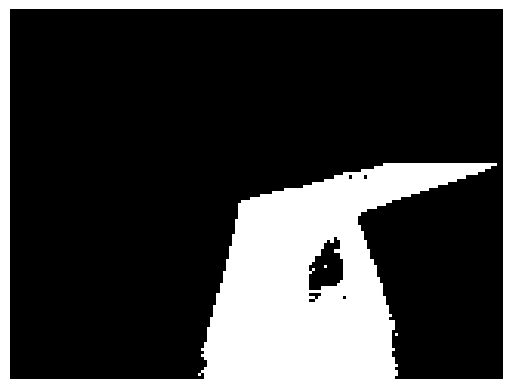

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [7]:
# FILTER BLACK PIXELS
black_mask = cv2.inRange(frame, lower_black, upper_black)
mostrar_imagen_bgr(black_mask)
x_black = cv2.bitwise_and(x_com, x_com, mask=black_mask)

print(x_black)
# scale such that bottom pixels have more weight
x_black *= (1 - y_com)
y_black = cv2.bitwise_and(y_com, y_com, mask=black_mask)
print(y_black)

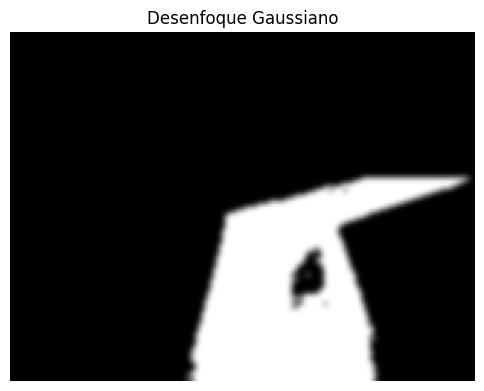

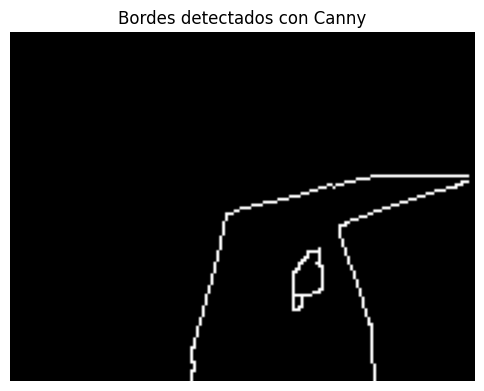

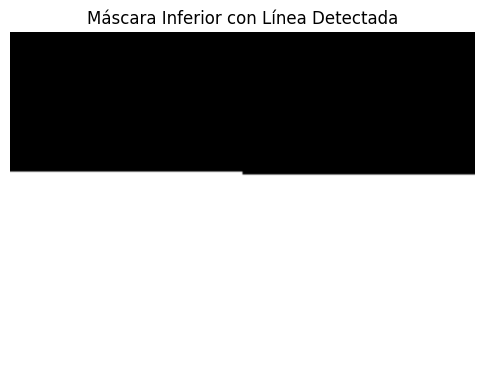

In [8]:
# Paso 1: Aplicar desenfoque gaussiano
blurred = cv2.GaussianBlur(black_mask, (5, 5), 0)
mostrar_imagen_gris(blurred, "Desenfoque Gaussiano")

# Paso 2: Detectar bordes con Canny
edges = cv2.Canny(blurred, 50, 200)
mostrar_imagen_gris(edges, "Bordes detectados con Canny")

# Paso 3: Detectar líneas con HoughLines
lines = cv2.HoughLines(edges, rho=1, theta=np.pi / 180, threshold=30)
# Crear una imagen de líneas vacía para visualizarlas
line_img = np.zeros_like(edges)
minY = 1000  # valor inicial arbitrariamente alto

# Máscara inferior vacía
bottom_mask = np.zeros(shape=(height, width), dtype=np.uint8)

if lines is not None:
    # Filtrar y ordenar las líneas
    lines = [[line[0][0], line[0][1]] for line in lines]
    lines = sorted(lines, key=lambda x: abs((x[1]/np.pi*180) - 90))

    rho, theta = lines[0]  # Tomar la primera línea con el ángulo más cercano a 90 grados
    degrees = theta / np.pi * 180
    
    # Detectar líneas horizontales
    if 45 < degrees < 135:   
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho

        x1 = int(x0 + 200 * (-b))
        y1 = int(y0 + 200 * a)
        x2 = int(x0 - 200 * (-b))
        y2 = int(y0 - 200 * a)

        # Actualizar el valor más bajo de Y
        if height - max(y1, y2) < minY:
            minY = min(minY, height - y1)
            minY = min(minY, height - y2)

        # Crear el polígono con los puntos obtenidos
        pts = np.array([[x1, y1], [x2, y2], [160, 120], [0, 120]], np.int32)
        bottom_mask = cv2.fillPoly(bottom_mask, [pts], 255)

# Si no se detecta ninguna línea, establecer minY a 0
if minY == 1000:
    minY = 0

# Visualizar la máscara inferior
mostrar_imagen_gris(bottom_mask, "Máscara Inferior con Línea Detectada")

In [ ]:
x_resultant = np.mean(x_black)
print(f"x_resultant: {x_resultant}")
y_resultant = np.mean(y_black)
print(f"y_resultant: {y_resultant}")
angle = (math.atan2(y_resultant, x_resultant) / math.pi * 180) - 90
print(f"angle: {angle}")
speed = 15
# Esto es si encuentra un solo verde quiere saber de que lado quedo
if len(green_contours) == 1:
    print(f"Media de verdes: {np.mean(x_green)}")
    if np.mean(x_green) < 0:  # turn left
        green_state = 1
        angle = 45
        speed=40
    else:
        green_state = 2  # turn right
        angle = -45
        speed=40
#Esto es si encuentra doble verde
if len(green_contours) == 2:
    green_state = 3

# stop robot from turning if it sees nothing
if y_resultant == 0:
    angle = 0

if round(angle) + 90 < 20 or round(angle) + 90 > 160:
    speed=40

output = [255, speed,
        254, round(angle) + 90,
        253, green_state]
print(output)

x_resultant: 0.02799092339409722
y_resultant: 0.04695920138888889
angle: -30.797858467727444
Media de verdes: -0.045736328125
[255, 40, 254, 135, 253, 1]
